# <u> Zillow Clustering Project</u>

### Title: Factors Driving errors in the Z-estimates

### Data Source: Zillow, 2017 Single Household Homes

##### by,
>  Stephen Kipkurui | Zillow Team Data Scientist  | April, 2022
<hr>



# Project Overview


### This project report is a continuation of the Regression Project, March, 2022.  The goal with this project however is to explore new features (as well as the old features discussed in the last project) in understanding drivers for Zillow's e-estimate (log error). The approach includes implementation of clustering techniques in exploration of data. 

## Goal: - Predict drivers in z-estimates (log error)

> #### Import Libraries

In [163]:
# Import Main Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import User Defined Modules
import wrangle
import acquire
import evaluate
from wrangle import drop_and_rename

# Import Sklearn Modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans

# Import Stats Module
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

from datetime import datetime, date

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

<hr>

# Project Approach:

> ### Data Science Pipeline

<hr>


# <u>Planning</u>

- #### The stakeholder --> Zillow Data Science Team
- #### Business objective --> Implement model for predicting drivers for error in the z-estimate (build on progression model)
- #### Data source --> CodeUp\'s on-line SQL Database 2017 Zillow. (Date of acquisition: April, 2022).
- #### Brainstorming --> Zillow Data Science Team
- #### Deliverables --> Presentation (Friday, April 8 afternoon)

### Additional Setups 
- ##### GitHub Repository (<u>git@github.com:stephenkipkurui/regression-project.git</u>). 
- ##### Mitigate data leakage.
- ##### Document process and delivery report

### Moving on... What are the drivers for Z-estimate?


# <u>Data Acquisition</u>

> ## Get main Original DataFrame

In [2]:
# Acquire zillow dataframe

df = acquire.acquire_zillow()

Status: Acquiring data from csv file..


In [3]:
# Examine dataframe shape
df.shape

(52451, 68)

- Original DataFrame contains 52,451 rows & 68 columns 
- No data leakage

# <u>Prepare</u>

### Import wrangle.py
- ##### Dropped duplicates & null data rows

- ##### Renamed Columns:
    - Generalized format--> add space-bar between words for readability e.g {'bedroomcnt':'bed_count'}
    - Refer README.md Data Dictionary
                   
- ##### Outliers:
    - Removed outliers as follows:
        - Stripped __bathrooms  >  7.5__
        - Stripped __bedrooms over 8__
        - Stripped __Square feet over 12000 feet__
        - Stripped __full bathrooms counts over 6__
        - Retained homes __build after 1910__
        - Stripped __tax amount over 300,000__
        - Binned unit counts and stripped those over 1.25
        - Binned tax value counts and stripped those over 2
            
- ##### Missing Values: 
    - Removed columns with over 60% missing values 
    - Removed rows with over 75% missing values
    - Calculated mean average of columns and filled remaining nulls with mean 
    
- ##### Split Data 

    - Train: ------ 56%
    - Validate: --- 24%
    - Test: ------- 20%
  
- ##### Scaled Data (modeling data)
    - Scaled columns:
        - Bathroom count
        - Bedroom counts
        - Age of home
        - Property lot/ land size
        - Home's square feet
        - Tax amount

- ##### Engineered Columns: 
    - Binnned columns:
        - Square feet
        - Lot size
        - Age of home (calculates age till 2017)
        - Acres of land
        - Bathroom ratio (bathroom / bedrooms)
        
    - New column:
        - City
        
    - Clustered columns:
        - Square feet & tax value cluster
        - Bedrooms, age & lot size cluster 
    
- ##### Fips refference U.S. Federal resources (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)                   
                   


> ### Drop, rename & add new features

In [164]:
# Function call to add, drop, and rename
df = drop_and_rename()

Status: Acquiring data from csv file..


> ### Split the data into train, validate & test

In [13]:
# Check the shape integrity

train, validate, test = wrangle.split_data(df)

Train: 33568 rows, 60 cols
Validate: 8392 rows, 60 cols
Test: 10491 rows, 60 cols


> ### Fill nulls with overall mean

In [15]:
train = train.fillna(train.mean())
validate = validate.fillna(validate.mean())
test = test.fillna(test.mean())

In [17]:
train.head(2)

,basement_sqft,bath_cnt,bed_cnt,calc_square_feet,fips,fire_place_cnt,full_bath_cnt,garage_car_cnt,garage_total_sqft,has_hot_tub_or_spa,...,acres,acres_bin,sqft_bin,bedrooms_bin,structure_amount_per_sqft,structure_amount_sqft_bin,land_amount_per_sqft,lot_amount_sqft_bin,bath_bed_ratio,cola
30541,622.3125,1.0,3.0,1530.0,6037.0,1.202889,1.0,1.950871,495.580972,1.0,...,0.255303,0.3,0.4,0.3,27.658824,0.1,0.202320,0.0,0.333333,0
23571,622.3125,2.0,3.0,1447.0,6059.0,1.202889,2.0,2.000000,411.000000,1.0,...,0.139509,0.1,0.3,0.3,78.345543,0.3,37.959355,0.3,0.666667,0


> ### Percentage of Columns Dropped after Preparation

- ###### Dropped 36% nulls rows 
- ###### Dropped 8% columns  

# <u>Exploratory Data Analysis</u>

### Initial Questions:
- Q1. Does the size of __land (lot size)__ affect the errors in z-estimate?
- Q2. Does the __home square feet__ of homes affect z-estimate?
- Q3. Controlling __location (counties)__, how is the z-estimate affected?
- Q4. Controlling __tax value__, how is the z-estimate affected?
- Q5. Lastly how are the __age of the homes__ in counties affect z-estimates counties?
- Q6. How are the means average sizes of land and home square feet in different counties affect z-estimate.
#### What features are driving the log_error?
 > - Perform feature engineering with SelectKBest to identify drivers
 > - Do combined features have enhanced effect of log_error?

#### Confidence level (Alpha level) = 0.05 

> ### Visualize Raw Data

Interaction of variables


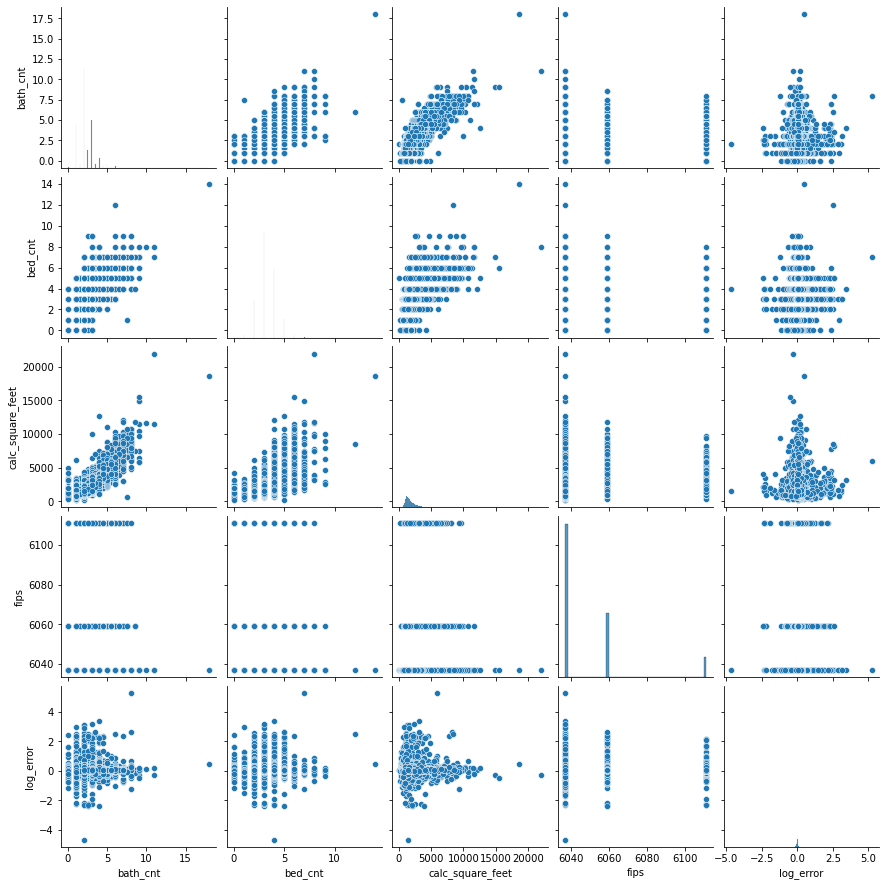

In [184]:
print("Interaction of variables")
sns.pairplot(train[['bath_cnt', 'bed_cnt', 'calc_square_feet','fips', 'log_error']])
plt.show()

Interaction of variables


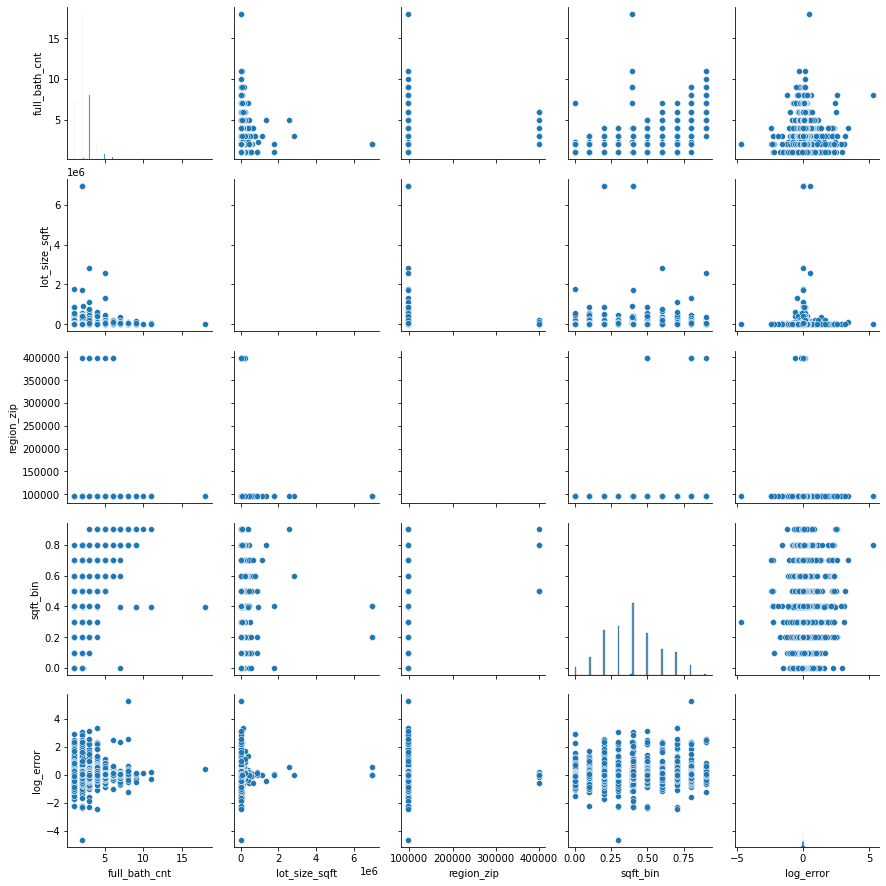

In [191]:
print("Interaction of variables")
sns.pairplot(train[['full_bath_cnt','lot_size_sqft','region_zip', 'sqft_bin', 'log_error']])
plt.show()

> ### Raw Data Summary
- ##### Strong correlations with log-error:
    - Bath count less than 2.5 
    - 2-4 bedroom homes have strong 
    - Square feet under 5000
    - Fips 6040--> 6100 --> 6080
    - full bath under 5
    - Lot size under bin 1

> ### (i). Lot size VS log error

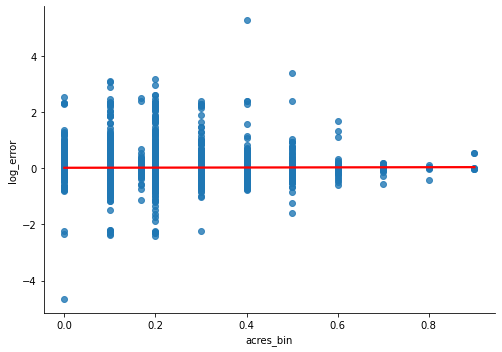

In [51]:
# Create lmplot showing regression
sns.lmplot(x="acres_bin", y="log_error", data = train, 
            height = 5, aspect = 11.7/8.27, line_kws={'color': 'red'})

> ### T-Test (PearsonR) - Lot Size

In [298]:
# Set alpha level
alpha = 0.05
# Hypothesis
H0 = 'There is no correlation between homes land size and z-estimate error'
H1 = 'Homes land size affects z-estimate error'
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.lot_size_sqft, train.log_error)
print(f'\tCorrelation Coefficient (r value): {r}\n\tP-value: {p}')
if p < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT HO:- {H0}")
print('\n\t\tInterpretation---> There is LOT SIZE Relationship')

	Correlation Coefficient (r value): 0.00884499171655652
	P-value: 0.10512215121949503

	REJECT HO:- There is no correlation between homes land size and z-estimate error

		Interpretation---> There is LOT SIZE Relationship


> ### (ii). Home square feet VS log error

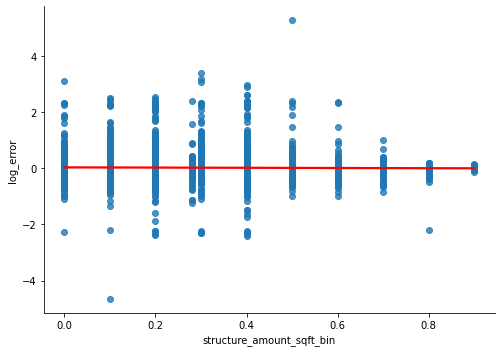

In [70]:
# Create lmplot showing regression
sns.lmplot(x="structure_amount_sqft_bin", y="log_error", data = train, 
            height = 5, aspect = 11.7/8.27, line_kws={'color': 'red'})

> ### T-Test (PearsonR) - Square Feet

In [297]:
H0 = 'There is no correlation between homes square feet and z-estimate error'
H1 = 'Homes square feet affects z-estimate error'
alpha = 0.05
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.sqft_bin, train.log_error)
print(f'\n\tCorrelation Coefficient: {r}\n\tP-value: {p}\n')
if p < alpha:
    print(f"\n\tFAILED TO REJECT HO:- {H0}")
else:
    print(f"\n\tREJECT:- {H0}")
print('\nInterpretation---> No SQUARE FEET Relationship')


	Correlation Coefficient: 0.032369049220222074
	P-value: 2.995364417541659e-09


	FAILED TO REJECT HO:- There is no correlation between homes square feet and z-estimate error

Interpretation---> No SQUARE FEET Relationship


> ### (iv). Location VS log error

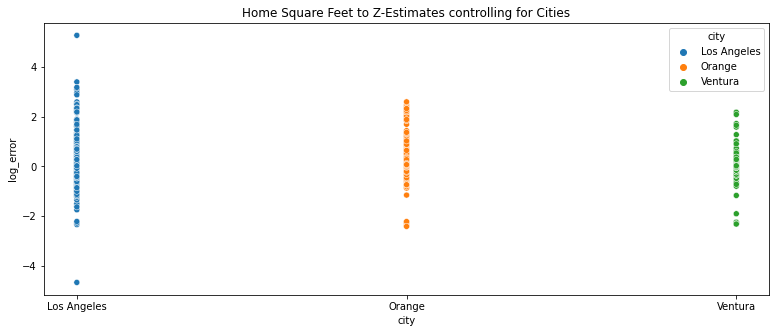

In [194]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='city', y='log_error', data=train, hue='city')
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.show()

> ### T-Test(Levene) - Cities

In [292]:
H_0 = 'There is no correlation between different cities homes locations and z-estimate error'
H_1 = 'Homes square feet in different cities affects z-estimate error same way'
stat, p = stats.levene(train[train.city == 'Los Angeles'].lot_size_sqft, 
             train[train.city == 'Orange'].lot_size_sqft, 
             train[train.city == 'Ventura'].lot_size_sqft)
stat, p

(7.946681776523836, 0.00035450044611771243)

In [296]:
if p / 2 < alpha:
    print(f"\n\tFAILED TO REJECT HO:- {H_0}\n")
else:
    print(f"\n\tREJECT HO:- {H_0}\n")
    
print('Interpretation---> There is CITIES relationship')


	REJECT HO:- There is no correlation between different cities homes locations and z-estimate error

Interpretation---> There is CITIES relationship


> ### (v). Tax VS log error

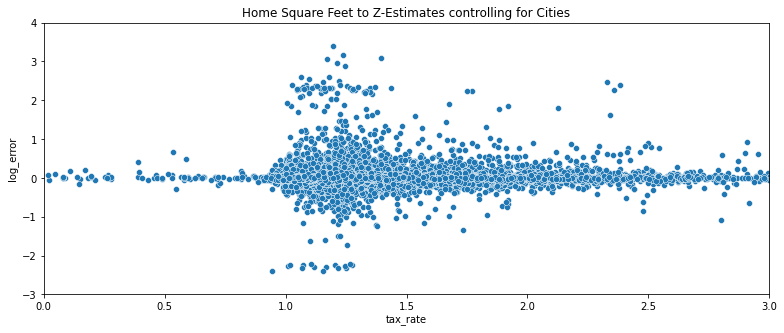

In [274]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='tax_rate', y='log_error', data = train)
plt.title('Home Square Feet to Z-Estimates controlling for Cities')
plt.xlim(0, 3)
plt.ylim(-3, 4)
plt.show()

> ### T-Test(PearsonR) - Tax

In [295]:
# Set alpha level
alpha = 0.05
# Hypothesis
H0 = 'No correlation between homes tax rate and z-estimate error'
H1 = 'Homes Tax rate affects z-estimate error'
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.tax_rate, train.log_error)
print(f'\tCorrelation Coefficient (r value): {r}\n\tP-value: {p}')
if p < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT HO:- {H0}")
print('\n\t\tInterpretation---> There is TAX Relationship')

	Correlation Coefficient (r value): 0.006209118927904751
	P-value: 0.25529724051886177

	REJECT HO:- No correlation between homes tax rate and z-estimate error

		Interpretation---> There is TAX Relationship


> ### (vi). Home Age VS log error

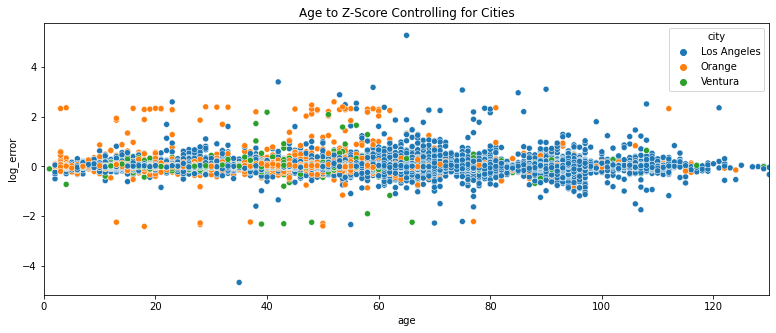

In [284]:
plt.figure(figsize = (13, 5))
sns.scatterplot(x='age', y='log_error', data=train, hue = 'city')
plt.title('Age to Z-Score Controlling for Cities')
plt.xlim(0, 130)
plt.show()

In [287]:
# Set alpha level
alpha = 0.05
# Hypothesis
H0 = 'No correlation between homes age and z-estimate error'
H1 = 'Homes age affects z-estimate error'
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
r, p = pearsonr(train.age, train.log_error)
print(f'\tCorrelation Coefficient (r value): {r}\n\tP-value: {p}')
if p < alpha:
    print(f"\n\tFAILED TO REJECT:- {H0}\n")
else:
    print(f"\n\tREJECT HO:- {H0}")
print('\n\t\tInterpretation---> Negative Relationship')

	Correlation Coefficient (r value): -0.01990177693088044
	P-value: 0.0002657912653204848

	FAILED TO REJECT:- No correlation between homes age and z-estimate error


		Interpretation---> Negative Relationship


> ### Top Drivers for Z-estimate (SelectKBest)
  - Bathroom count
  - Bedroom count
  - Square feet
  - Zip code (fips)
  - Full bath counts
  - Latitude
  - Longitude
  - Lot size square feet
  - Census track & block
  - Property region 
  - Room counts
  - Unit counts
  - Year home built (age)
  - Tax value
  - Tax Amount

> ## Clustering (KMeans)
#### (I). With 2 features 
- Home Square feet
- Tax Amount)

In [234]:
# Create X onject and predict kmeans
X = train_scaled[['calc_square_feet',  'tax_amount']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
kmeans.predict(X)
train_scaled['sqft_tax_cluster'] = kmeans.predict(X)

> ### Visualize the clusters 
- Squre Feet Key:
  - bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
  - labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

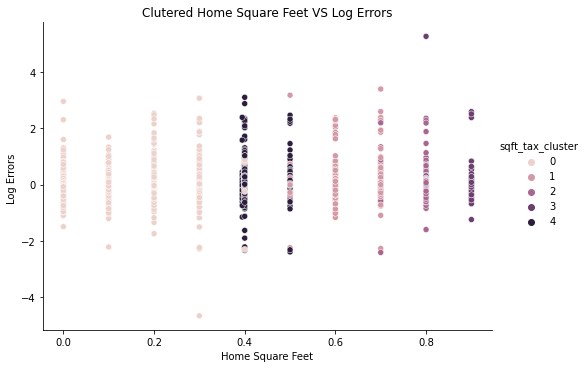

In [235]:
sns.relplot(data = train_scaled, x = 'sqft_bin', y = 'log_error',
            hue='sqft_tax_cluster', height = 5, aspect = 11.7 / 8.27)
plt.title('Clutered Home Square Feet VS Log Errors')
plt.xlabel('Home Square Feet')
plt.ylabel('Log Errors ')
# plt.xlim(-1000, 12000)
plt.show()

In [238]:
# Cluster for each cluster
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

### Group Features by Clusters
- Square feet 
- tax amount


In [239]:
# Group by clusters
train_scaled.groupby('sqft_tax_cluster')['log_error','calc_square_feet',  'tax_amount'].mean()

,log_error,calc_square_feet,tax_amount
sqft_tax_cluster,,,
0,0.014930,0.048012,0.006219
1,0.025702,0.125534,0.015906
2,0.034085,0.195324,0.033917
3,0.116194,0.361870,0.105758
4,0.015746,0.080732,0.009542


### -----> Cluster I, Summary (tax amount and square feet)
- ##### Tax amount affects log-error (confimed by t-test)
- Square feet --> No effect

### (ii). 3 Clustering with 3 Features:- 
- Bed Count
- Age 
- Home Lot Size

Number of clusters == 4 

Text(0.5, 0.98, "clusters based on ['bed_cnt', 'age', 'lot_size_sqft']")

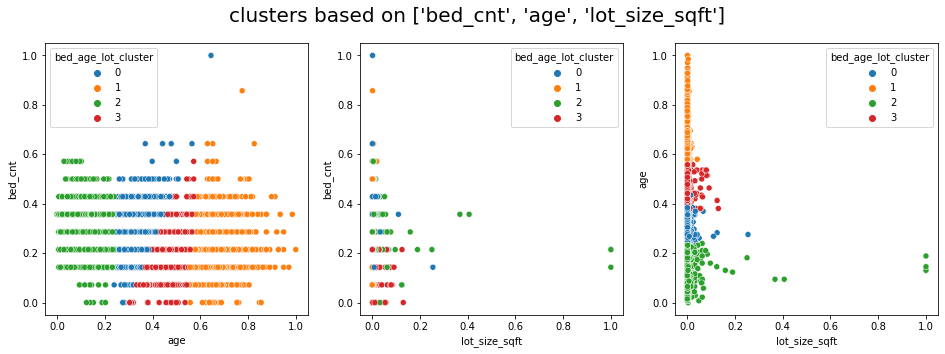

In [244]:
X2 = train_scaled[['bed_cnt','age', 'lot_size_sqft']]
kmeans = KMeans(n_clusters = 4) # Computed by elbow model
kmeans.fit(X2)
train_scaled['bed_age_lot_cluster'] = kmeans.labels_
train_scaled.bed_age_lot_cluster = train_scaled.bed_age_lot_cluster.astype('category')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

sns.scatterplot(data=train_scaled, y='bed_cnt', x='age', hue='bed_age_lot_cluster', ax=ax1)
sns.scatterplot(data=train_scaled, y='bed_cnt', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax2)
sns.scatterplot(data=train_scaled, y='age', x='lot_size_sqft', hue='bed_age_lot_cluster', ax=ax3)
fig.suptitle(f'clusters based on {X2.columns.tolist()}', size = 20)

In [243]:
# Group by clusters
train_scaled.groupby('bed_age_lot_cluster')['log_error','bed_cnt','age', 'lot_size_sqft'].mean()

,log_error,bed_cnt,age,lot_size_sqft
bed_age_lot_cluster,,,,
0,0.008409,0.193887,0.660424,0.001036
1,0.022013,0.269068,0.144363,0.002739
2,0.015974,0.210105,0.461339,0.001318
3,0.023965,0.263464,0.334220,0.001461


### ----> Cluster II, Summary (bedrooms, home age, lot size)
- ##### Lot size has significant effect on log error (Confirmed by t-test)

## Exploration TakeAways:
>### Log Error Greatest In:
- __Bed count 2-4__ followed by 5 and 1
- __Bathroom counts 1, 2, 3, 4__
- __Tax rate (binned) between 1.0- 1.5__ and skews right to 3.0 (tax rate = tax amount / tax count)
- __Los Angeles has higher tax rate__ followed by Orange and least Ventura
- Homes with __square feet around 1500 have high log errors__, skews right to about 6000 square feet.
- Majority of __1500 square feet homes with high log-errors are in Los Angeles__, followed by Orange County. 
> ### Even distribution of Log Errors:
- __Age of home__ 
- __Latitude and Longitude__  


> ### Features Moving into Modeling:
- Bathroom (1 - 7.5)
- Bedroom count (0 - 8)
- Age of Home (Homes built after 1910)
- Lot Size
- Square feet (Single Family Homes < 12000)

# <u>Modeling</u>

- Baseline
- Linear Regression
- Lasso + Lars
- Polynomial Regression

> ### Acquire Scaled Data For Modeling (MinMaxScaler)

In [113]:
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train, validate, test)

### (A). Create Baseline

In [118]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict log_error_pred_mean
log_error_pred_mean = y_train['log_error'].mean()
y_train['log_error_pred_mean'] = log_error_pred_mean
y_validate['log_error_pred_mean'] = log_error_pred_mean
# 2. RMSE of log_error_pred_mean
rmse_train_bl = mean_squared_error(y_train.log_error, y_train.log_error_pred_mean)**(1/2)
rmse_validate_bl = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_mean)**(1/2)

print("RMSE Baseline (Mean)\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))

RMSE Baseline (Mean)
	Train-In-Sample:  0.18 
	Validate/Out-of-Sample:  0.19


### B). Linear Regression (Best Model)

In [252]:
# create the model object
lm = LinearRegression(normalize = True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.log_error)
# predict train
y_train['log_error_pred_lm'] = lm.predict(X_train)
# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm)**(1/2)
# predict validate
y_validate['log_error_pred_lm'] = lm.predict(X_validate)
# evaluate: rmse
# rmse_validate_lr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm)**(1/2)
# print("RMSE for OLS using LinearRegression\n\tTraining/In-Sample: ", rmse_train_lr, 
#       "\n\tValidation/Out-of-Sample: ", rmse_validate_lr)

### C). Lasso + Lars

In [253]:
# create the model object
lars = LassoLars(alpha = 1.0)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.log_error)
# predict train
y_train['log_error_pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train_ll = mean_squared_error(y_train.log_error, y_train.log_error_pred_lars)**(1/2)
# predict validate
y_validate['log_error_pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate_ll = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lars)**(1/2)
# print("RMSE for LASSO + LARS\n\tTraining/In-Sample: ", rmse_train_ll, 
#       "\n\tValidation/Out-of-Sample: ", rmse_validate_ll)

### D). Polynomial Regression 

In [299]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)
# create the model object
lm2 = LinearRegression(normalize = True)
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.log_error)
# predict train
y_train['log_error_pred_lm2'] = lm2.predict(X_train_degree2)
# evaluate: rmse
rmse_train_pr = mean_squared_error(y_train.log_error, y_train.log_error_pred_lm2)**(1/2)
# predict validate
y_validate['log_error_pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: rmse
rmse_validate_pr = mean_squared_error(y_validate.log_error, y_validate.log_error_pred_lm2)**(1/2)
# print("RMSE for Polynomial Model, degrees=2\n\tTraining/In-Sample: ", rmse_train_pr, 
#       "\n\tValidation/Out-of-Sample: ", rmse_validate_pr)

### Errors in Predictions

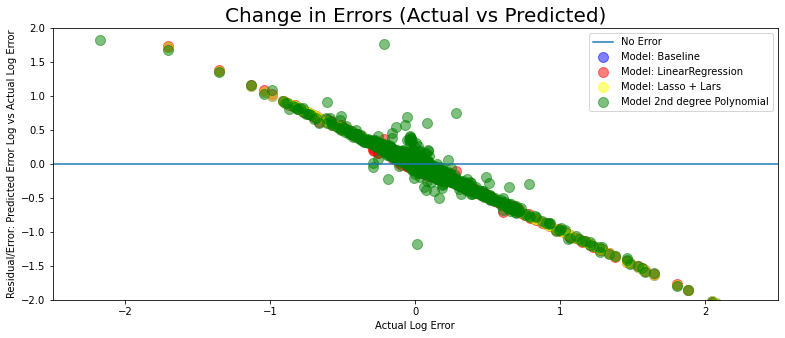

In [255]:
# y_validate.head()
plt.figure(figsize=(13,5))
plt.axhline(label="No Error")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_mean-y_validate.log_error, 
            alpha=.5, color="blue", s=100, label="Model: Baseline")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm-y_validate.log_error, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lars-y_validate.log_error, 
            alpha=.5, color="yellow", s=100, label="Model: Lasso + Lars")
plt.scatter(y_validate.log_error, y_validate.log_error_pred_lm2-y_validate.log_error, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Error Log vs Actual Log Error")
plt.title("Change in Errors (Actual vs Predicted)", size = 20)
plt.ylim(-2, 2)
plt.xlim(-2.5, 2.5)
plt.show()

In [271]:
print('--RMSE:--')
print("\nBASELINE (Mean)\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))
print('==========================================================')
print("\nLINEAR REGRESSION (***Best Model Overall***)\n\tTraining/In-Sample: ", rmse_train_lr, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_lr)
print('==========================================================')
print("\nLASSO + LARS\n\tTraining/In-Sample: ", rmse_train_ll, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_ll)

print("\nPOLYNOMIAL REGRESSION, degrees=2\n\tTraining/In-Sample: ", rmse_train_pr, 
      "\n\tValidation/Out-of-Sample: ", rmse_validate_pr)

--RMSE:--

BASELINE (Mean)
	Train-In-Sample:  0.18 
	Validate/Out-of-Sample:  0.19

LINEAR REGRESSION (***Best Model Overall***)
	Training/In-Sample:  0.17929175028034303 
	Validation/Out-of-Sample:  0.18842820727756016

LASSO + LARS
	Training/In-Sample:  0.17976292017031315 
	Validation/Out-of-Sample:  0.1885714703115021

POLYNOMIAL REGRESSION, degrees=2
	Training/In-Sample:  0.17721619219471793 
	Validation/Out-of-Sample:  0.19520093197298863


### Best Model (Linear Regression) on Test Data

In [273]:
y_test = pd.DataFrame(y_test)
# predict on test
y_test['log_error_pred_lm'] = lm.predict(X_test)
# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.log_error_pred_lm)**(1/2)
print("\nBASELINE (Mean)\n\tTrain-In-Sample: ", round(rmse_train_bl, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate_bl, 2))
print('==========================================================')
print("RMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test)
print('==========================================================')


BASELINE (Mean)
	Train-In-Sample:  0.18 
	Validate/Out-of-Sample:  0.19
RMSE for OLS Model using LinearRegression
	Out-of-Sample Performance:  0.1591094033350667


### Modeling Summary 
- Baseline Log Error Value: __0.19__
- __Linear Regression__ Log Error Value (best model on test data): __0.1590__
- Our model performed 45% better than the baseline.


### Key Findings 
- Consistent drivers- __Tax amount & Lot size__ (cluster & t-test)
- Very minimal significance across features
- Further review of Tax & Lot size (new features)

## Recommendation 


- Most features show very minimal variance predicting log error. 
- No significant observation, continue exploring with more information on lot size:
        e.g - proximity to school
            - Health facilities
            - Community population ecomonic index, age etc
- More information == more play with data